# 1. Data Load

In [1]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 
from pickle import dump

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
path = "./Dataset/"

data = pd.read_csv(path+"train.csv")

# original data -> data
data

,index,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
0,0,1.0,5.0,5.0,5.0,1.0,4.0,5.0,5.0,1.0,...,1.0,20,2.0,12.0,4.0,2.0,1.0,4.0,2.0,1
1,1,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,...,1.0,49,1.0,2.0,1.0,1.0,2.0,4.0,2.0,1
2,2,4.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,4.0,...,2.0,43,1.0,2.0,2.0,2.0,3.0,4.0,2.0,1
3,3,4.0,4.0,4.0,2.0,4.0,3.0,3.0,5.0,3.0,...,1.0,17,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1
4,4,4.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,...,2.0,18,2.0,12.0,1.0,2.0,1.0,1.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2.0,5.0,4.0,3.0,3.0,4.0,4.0,4.0,3.0,...,1.0,17,1.0,1.0,3.0,2.0,1.0,3.0,2.0,0
14996,14996,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,...,2.0,45,1.0,3.0,1.0,1.0,2.0,3.0,2.0,1
14997,14997,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,...,1.0,20,1.0,1.0,2.0,1.0,1.0,3.0,1.0,1
14998,14998,5.0,5.0,4.0,5.0,5.0,5.0,5.0,1.0,5.0,...,1.0,29,1.0,12.0,4.0,2.0,2.0,2.0,1.0,0


# 2. EDA 

15,000 rows × 70 columns

- feature (1)
    - index 
- Categorical variable (63)
    - country : 137 values, not valanced 
    - education : 4 values 
    - urban : 4 values, but start with 0 
    - gender : 3 
    - engnat : 2 
    - hand : 3 
    - religion : 12 
    - orientation : 5
    - voted : 2
    - married : 3
    - ASD : 2 
    - Q(26) : 5 values
        - 1=Disagree, 2=Slightly disagree, 3=Neutral, 4=Slightly agree, 5=Agree
    - TIPI(10) : 5 values 
        - items were rated "I see myself as:" _____ such that Extraverted, enthusiastic...
    - VCL(16) : 2 values (0 or 1) 
- Numerical variable (5)
    - introelapse : 1315 values 
    - testelapse : 684 values 
    - surveyelapse : 712 values
    - age : 76 values, but maybe outlier...
    - familysize : 20 values, but maybe outlier... 
- Y variable (1)
    - nerdiness 
        - binary classification 
        - 1:8303, 0:6697

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 70 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         15000 non-null  int64  
 1   Q1            14959 non-null  float64
 2   Q2            14931 non-null  float64
 3   Q3            14950 non-null  float64
 4   Q4            14929 non-null  float64
 5   Q5            14962 non-null  float64
 6   Q6            14952 non-null  float64
 7   Q7            14924 non-null  float64
 8   Q8            14952 non-null  float64
 9   Q9            14944 non-null  float64
 10  Q10           14928 non-null  float64
 11  Q11           14941 non-null  float64
 12  Q12           14933 non-null  float64
 13  Q13           14960 non-null  float64
 14  Q14           14964 non-null  float64
 15  Q15           14955 non-null  float64
 16  Q16           14967 non-null  float64
 17  Q17           14963 non-null  float64
 18  Q18           14937 non-nu

<AxesSubplot:>

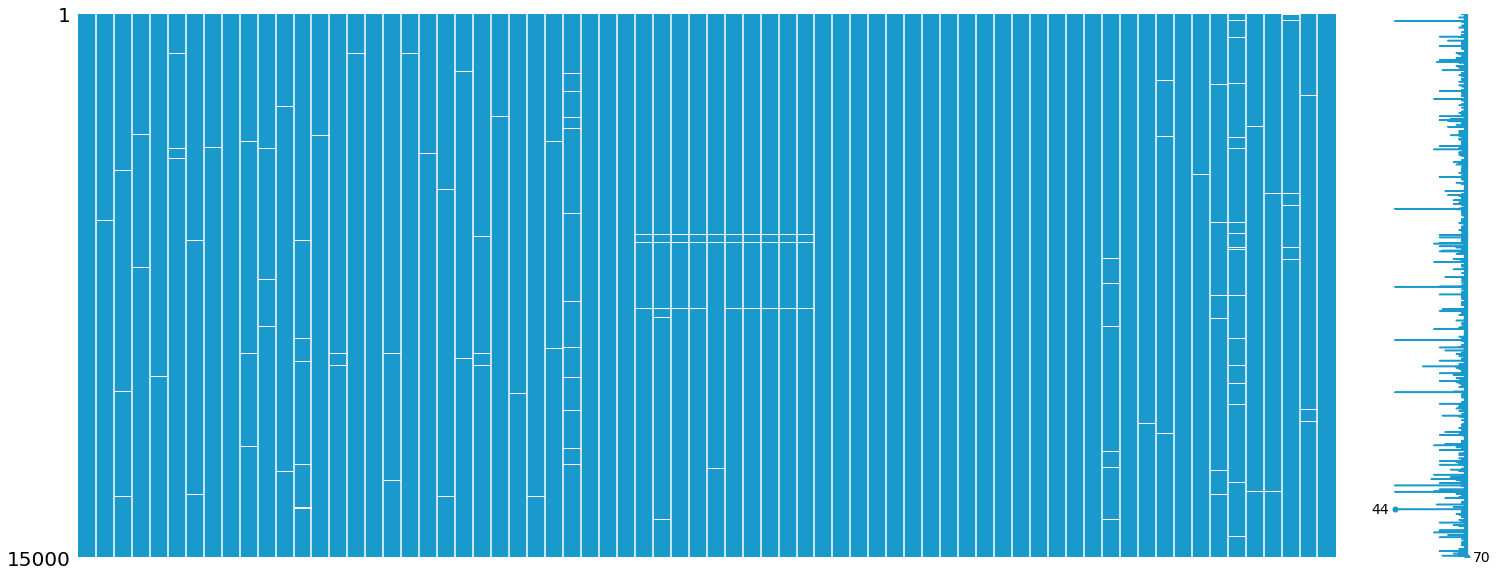

In [4]:
# missing value check
msno.matrix(data.iloc[:, :], color=(0.1, 0.6, 0.8))

# 3.1. Preprocessing - TrainData
data -> processed_data (**15,000 x 70 -> 15,000 x 50**)

Basic 
- **Drop unnecessary features** 
    - index, country(...)
- **Handling missing values (...)**
    - **fillna 0**
        - education, gender, hand, religion, orientation, voted, married, ASD
        - 무응답은 0으로 채우기 (urban은 이미 0부터 시작) 
    - **imputation : simple method**
        
Question (Q, TIPI, VCL)
- TIPI scoring to 'O', 'C', 'E', 'A', 'N' 
- VCL scoring (he words at **VCL6, VCL9, and VCL12** are not real words and can be used as a validity check)

    
Numerical
- **Log Transformation**
    - 3 elapse cols (intro, test, survey)
- **Ranging**
    - 'age' to 10 category (0~10/10~20..90~100)
- **Handling outlier**
    - 'familysize' to make np.Nan and imputate


In [299]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 
# Feature drop 
# 'index', 'country'
processed_data = data.drop(['index'], axis=1).copy()

In [300]:
# # Handling missing values with simple imputator
# # 'education', 'gender', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'
# from sklearn.impute import SimpleImputer

# fill_cols = ['education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD']
# transformer = SimpleImputer()
# processed_data[fill_cols] = transformer.fit_transform(processed_data[fill_cols])
# processed_data[fill_cols].describe()

In [301]:
# Handling missing values with 0
# 'education', 'gender', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'

fill_cols = ['education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD', 'country']
processed_data[fill_cols] = processed_data[fill_cols].fillna(0)
processed_data[fill_cols].isna().sum()

education      0
gender         0
engnat         0
hand           0
religion       0
orientation    0
voted          0
married        0
ASD            0
country        0
dtype: int64

In [302]:
# country
country_nerdL = ['SWE', 'DEU', 'USA']
country_nerdM = ['NLD', 'ITA', 'GBR', 'AUS', 'POL', 'CAN', 'FRA', 'IDN', 'BRA', 'NOR', 'FIN']
country_nerdS = ['PHL', 'NZL', 'MYS', 'MEX', 'IND', 'SGP']

# Lable Encoding : 'country' 
from sklearn.preprocessing import LabelEncoder

# missing values as 0 
processed_data['country'] = processed_data['country'].fillna(0)
# labeling top countries as 2, 3, 4
processed_data['country'] = processed_data['country'].apply(lambda x : 2 if x in country_nerdL else x)
processed_data['country'] = processed_data['country'].apply(lambda x : 3 if x in country_nerdM else x)
processed_data['country'] = processed_data['country'].apply(lambda x : 4 if x in country_nerdS else x)
# labeling other countries as 1
processed_data['country'] = processed_data['country'].apply(lambda x : 1 if x not in [0, 2, 3, 4] else x)

# check
print(processed_data['country'].unique())

[2 3 1 4 0]


In [303]:
# # Lable Encoding : 'country' 
# from sklearn.preprocessing import LabelEncoder

# # missing values as 0 
# processed_data['country'] = processed_data['country'].fillna(0)

# # labeling the other countries as 1 
# df_country = pd.DataFrame(data['country'].value_counts())
# others = df_country[df_country['country']==1].index.values.tolist()
# processed_data['country'] = processed_data['country'].apply(lambda x : 1 if x in others else x)

# le_cnt = LabelEncoder()
# processed_data['country'] = le_cnt.fit_transform(list(processed_data['country']))   
# print(le_cnt.classes_)

# # save encoder
# dump(le_cnt, open('labelencoder.pkl', 'wb'))

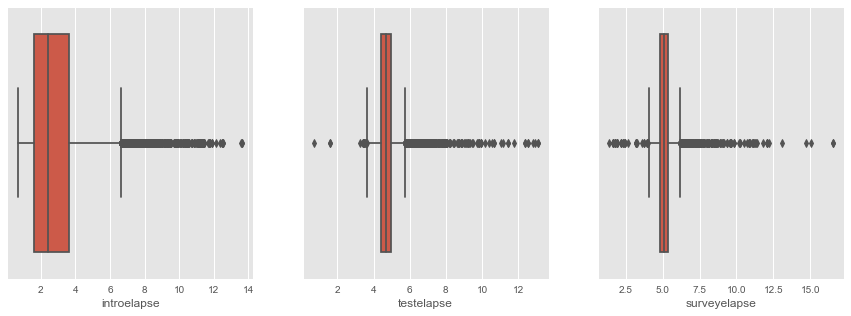

In [304]:
# Log Transformation
# 'introelapse','testelapse','surveyelapse'
right_skewed_cols = ['introelapse','testelapse','surveyelapse']
for c in right_skewed_cols : 
    processed_data[c] = np.log1p(processed_data[c])

# for checking 
plt.style.use("ggplot") 
plt.figure(figsize=(15,5))
    
for i in range(len(right_skewed_cols)):
    plt.subplot(1,3,i+1)
    sns.boxplot(x=right_skewed_cols[i], data=processed_data)

In [305]:
# Ranging and Ordinary Encoding 
# 'age'
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder

bins= [10,20,30,40,50,60,70,80,90,100,40000]
labels = [10,20,30,40,50,60,70,80,90,100]
processed_data['age'] = pd.cut(processed_data['age'], bins=bins, labels=labels, right=False)

oe = OrdinalEncoder()
processed_data['age'] = oe.fit_transform(processed_data['age'].values.reshape(-1,1))
processed_data['age'].value_counts()

0.0    6824
1.0    5161
2.0    1493
3.0     822
4.0     459
5.0     202
6.0      28
9.0       7
7.0       3
8.0       1
Name: age, dtype: int64

count    15000.000000
mean         2.298851
std          0.836876
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: familysize, dtype: float64


<AxesSubplot:xlabel='familysize'>

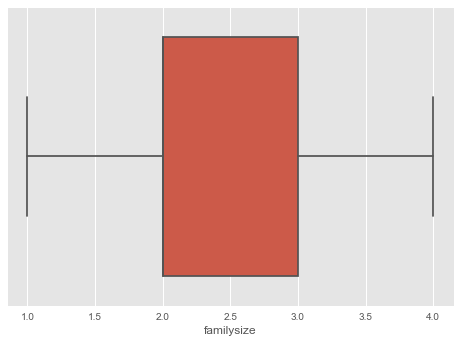

In [306]:
# Handling outlier
# 'familysize'
Q1 = processed_data['familysize'].quantile(0.25)
Q2 = processed_data['familysize'].quantile(0.5)
Q3 = processed_data['familysize'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)
processed_data['familysize'] = processed_data['familysize'].apply(lambda x : np.nan if x < lower_fence or x > upper_fence else x)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
transformer =  IterativeImputer()
processed_data[['familysize', 'nerdiness']] = transformer.fit_transform(processed_data[['familysize', 'nerdiness']])
print(processed_data['familysize'].describe())
sns.boxplot(x='familysize', data=processed_data)

In [307]:
# # finish handling missing values! 
# npas_cols = ['Q{}'.format(i) for i in range(1,27)]
# tipi_cols = ['TIPI{}'.format(i) for i in range(1,11)]
# vcl_cols = ['VCL{}'.format(i) for i in range(1,17)]
# mach_cols = ['Q{}'.format(i) for i in range(1,21)]
# nomach_cols = ['Q{}'.format(i) for i in range(21,27)]
# q_cols = [npas_cols, tipi_cols, vcl_cols]

# for col in q_cols : 
#     transformer = SimpleImputer()
#     processed_data[col] = transformer.fit_transform(processed_data[col])
    
# msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

<AxesSubplot:>

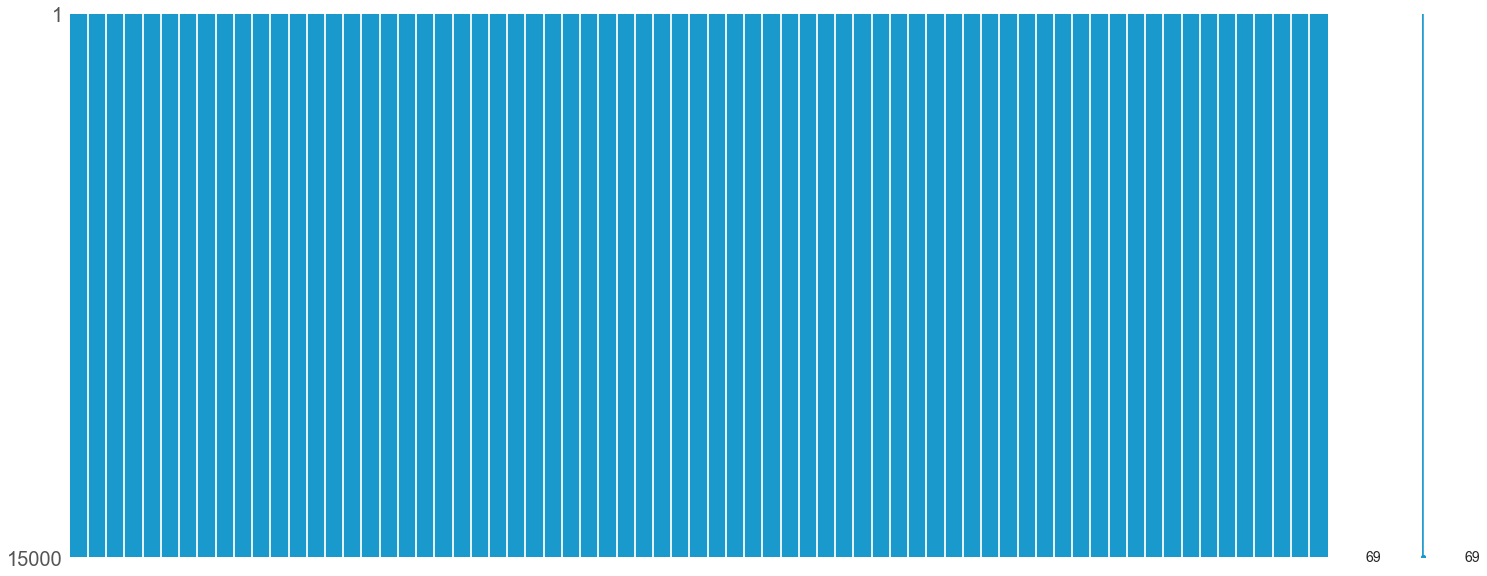

In [308]:
# finish handling missing values! 
npas_cols = ['Q{}'.format(i) for i in range(1,27)]
tipi_cols = ['TIPI{}'.format(i) for i in range(1,11)]
vcl_cols = ['VCL{}'.format(i) for i in range(1,17)]
mach_cols = ['Q{}'.format(i) for i in range(1,21)]
nomach_cols = ['Q{}'.format(i) for i in range(21,27)]
q_cols = [npas_cols, tipi_cols, vcl_cols]

for col in q_cols : 
    #transformer = SimpleImputer()
    processed_data[col] = processed_data[col].fillna(0)
    
msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

In [309]:
def score_mach(data) :
    rev_cols = ['Q3', 'Q4', 'Q7', 'Q9', 'Q10', 'Q11', 'Q16', 'Q17', 'Q14', 'Q18']
    for flip in rev_cols: 
        data[flip] = 6 - data[flip]
    data['Mach'] = data[mach_cols].sum(axis=1)
    #data.drop(mach_cols, axis=1, inplace = True)
    return data 

processed_data = score_mach(processed_data)
processed_data['Mach']

0        61.0
1        62.0
2        60.0
3        59.0
4        59.0
         ... 
14995    63.0
14996    56.0
14997    60.0
14998    53.0
14999    59.0
Name: Mach, Length: 15000, dtype: float64

In [310]:
def score_tipi(data) :
    data['E'] = (data['TIPI1'] + (8-data['TIPI6'])) / 2
    data['A'] = (data['TIPI7'] + (8-data['TIPI2'])) / 2
    data['C'] = (data['TIPI3'] + (8-data['TIPI8'])) / 2
    data['N'] = (data['TIPI9'] + (8-data['TIPI4'])) / 2
    data['O'] = (data['TIPI5'] + (8-data['TIPI10'])) / 2
    data.drop(['TIPI1', 'TIPI2', 'TIPI3', 'TIPI4', 'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10'], axis=1, inplace = True)
    return data 

processed_data = score_tipi(processed_data)
processed_data[['E', 'A', 'C', 'N', 'O']]

,E,A,C,N,O
0,3.5,5.0,5.0,6.0,4.0
1,5.0,5.5,5.0,2.5,4.5
2,2.0,4.5,3.5,6.0,5.5
3,4.0,4.5,3.5,3.5,5.0
4,3.5,4.0,4.0,3.5,5.0
...,...,...,...,...,...
14995,2.5,4.5,4.5,4.0,4.0
14996,4.0,5.0,5.5,2.5,5.0
14997,2.0,4.0,3.5,2.0,4.0
14998,2.0,6.0,3.5,2.5,5.5


In [311]:
def score_vcl(data) :
    data['VCL_score'] = (data['VCL1'] + data['VCL2'] + data['VCL3'] + data['VCL4'] + data['VCL5'] + data['VCL7'] + data['VCL8']
                        + data['VCL10'] + data['VCL11'] + data['VCL13'] + data['VCL14'] + data['VCL15'] + data['VCL16'])
    data['VCL_faker'] = (data['VCL6'] + data['VCL9'] + data['VCL12'])
    data.drop(['VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 
               'VCL10', 'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16',], axis=1, inplace = True)
    return data 

processed_data = score_vcl(processed_data)
processed_data[['VCL_score', 'VCL_faker']]

,VCL_score,VCL_faker
0,8,0
1,11,0
2,11,0
3,9,0
4,8,0
...,...,...
14995,10,1
14996,8,0
14997,9,0
14998,11,1


<AxesSubplot:>

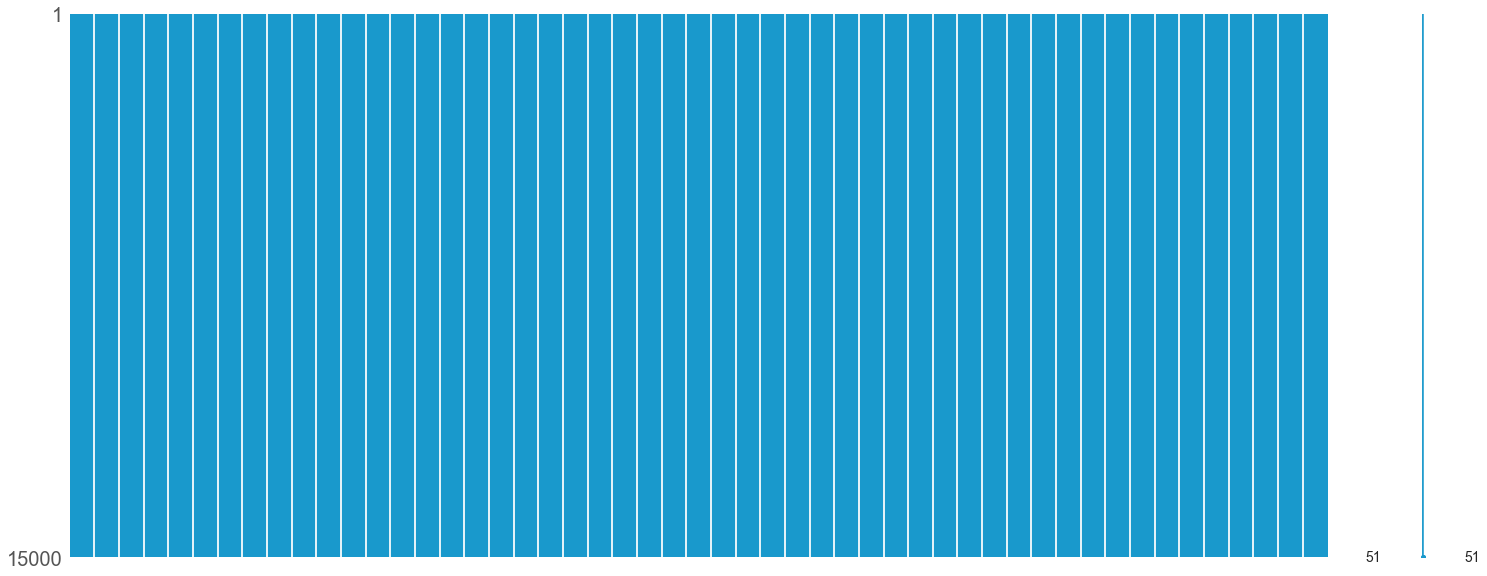

In [312]:
msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

# 3.2. Preprocessing - TestData
test -> test (**15,000 x 70 -> 15,000 x 50**)

In [245]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 
test = pd.read_csv(path+"test.csv")

# Feature drop : 'index'
test = test.drop(['index'], axis=1).copy()

# Handling missing values : 'education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'
from sklearn.impute import SimpleImputer
fill_cols = ['education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD', 'country']
test[fill_cols] = test[fill_cols].fillna(0)
print(test[fill_cols].isna().sum())

#labeling the other countries as 1 
country_nerdL = ['SWE', 'DEU', 'USA']
country_nerdM = ['NLD', 'ITA', 'GBR', 'AUS', 'POL', 'CAN', 'FRA', 'IDN', 'BRA', 'NOR', 'FIN']
country_nerdS = ['PHL', 'NZL', 'MYS', 'MEX', 'IND', 'SGP']
# Lable Encoding : 'country' 
from sklearn.preprocessing import LabelEncoder
# labeling top countries as 2, 3, 4
processed_data['country'] = processed_data['country'].apply(lambda x : 2 if x in country_nerdL else x)
processed_data['country'] = processed_data['country'].apply(lambda x : 3 if x in country_nerdM else x)
processed_data['country'] = processed_data['country'].apply(lambda x : 4 if x in country_nerdS else x)
# labeling other countries as 1
processed_data['country'] = processed_data['country'].apply(lambda x : 1 if x not in [0, 2, 3, 4] else x)
print(processed_data['country'].unique())

# Log Transformation : 'introelapse','testelapse','surveyelapse'
right_skewed_cols = ['introelapse','testelapse','surveyelapse']
for c in right_skewed_cols : 
    test[c] = np.log1p(test[c])

# Ranging and Ordinary encoding: 'age'
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
bins= [10,20,30,40,50,60,70,80,90,100,40000]
labels = [10,20,30,40,50,60,70,80,90,100]
test['age'] = pd.cut(test['age'], bins=bins, labels=labels, right=False)
oe = OrdinalEncoder()
test['age'] = oe.fit_transform(test['age'].values.reshape(-1,1))

# Handling outlier and iterative imputation : 'familysize'
Q1 = test['familysize'].quantile(0.25)
Q2 = test['familysize'].quantile(0.5)
Q3 = test['familysize'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)
test['familysize'] = test['familysize'].apply(lambda x : np.nan if x < lower_fence or x > upper_fence else x)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
transformer =  IterativeImputer()
test[['familysize']] = transformer.fit_transform(test[['familysize']])
test['familysize'] = test['familysize'].astype(int)
print(test['familysize'].describe())

education      0
gender         0
engnat         0
hand           0
religion       0
orientation    0
voted          0
married        0
ASD            0
country        0
dtype: int64
[2 3 1 4 0]
count    35452.000000
mean         2.268814
std          0.840906
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: familysize, dtype: float64


<AxesSubplot:>

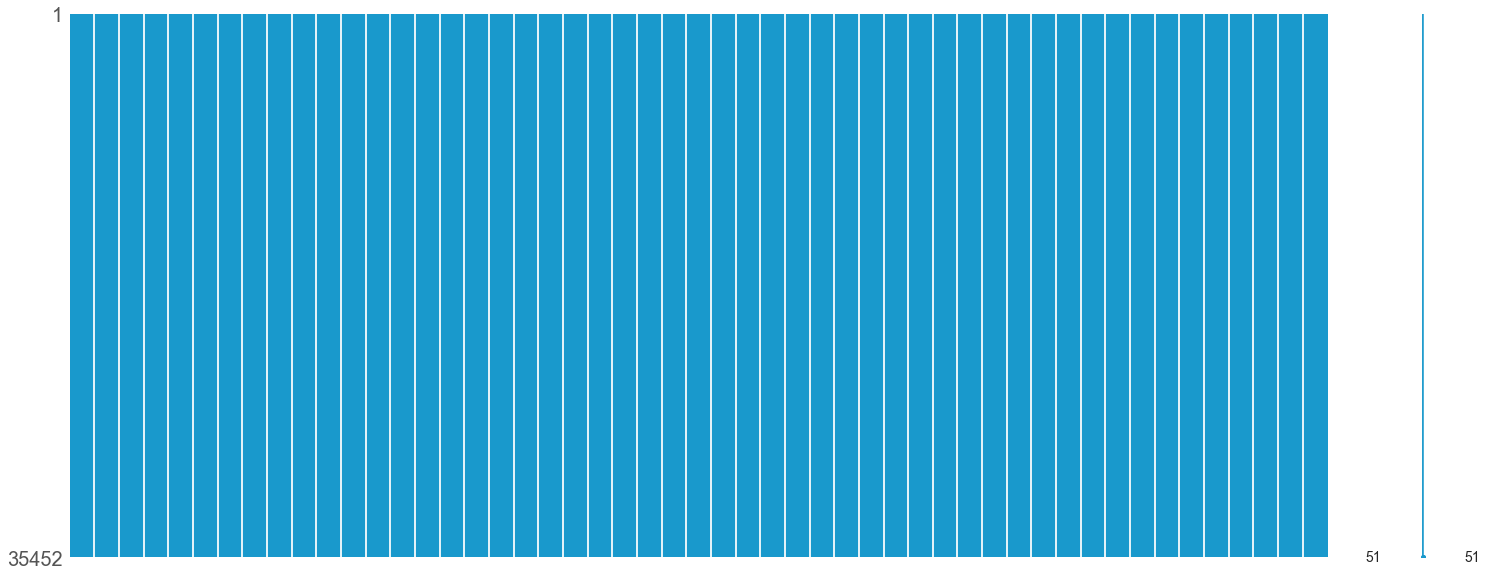

In [246]:
def score_mach(data) :
    rev_cols = ['Q3', 'Q4', 'Q7', 'Q9', 'Q10', 'Q11', 'Q16', 'Q17', 'Q14', 'Q18']
    for flip in rev_cols: 
        data[flip] = 6 - data[flip]
    data['Mach'] = data[mach_cols].sum(axis=1)
    #data.drop(mach_cols, axis=1, inplace = True)
    return data 

def score_tipi(data) :
    data['E'] = (data['TIPI1'] + (8-data['TIPI6'])) / 2
    data['A'] = (data['TIPI7'] + (8-data['TIPI2'])) / 2
    data['C'] = (data['TIPI3'] + (8-data['TIPI8'])) / 2
    data['N'] = (data['TIPI9'] + (8-data['TIPI4'])) / 2
    data['O'] = (data['TIPI5'] + (8-data['TIPI10'])) / 2
    data.drop(['TIPI1', 'TIPI2', 'TIPI3', 'TIPI4', 'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10'], axis=1, inplace = True)
    return data 

def score_vcl(data) :
    data['VCL_score'] = (data['VCL1'] + data['VCL2'] + data['VCL3'] + data['VCL4'] + data['VCL5'] + data['VCL7'] + data['VCL8']
                        + data['VCL10'] + data['VCL11'] + data['VCL13'] + data['VCL14'] + data['VCL15'] + data['VCL16'])
    data['VCL_faker'] = (data['VCL6'] + data['VCL9'] + data['VCL12'])
    data.drop(['VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 
               'VCL10', 'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16',], axis=1, inplace = True)
    return data 

npas_cols = ['Q{}'.format(i) for i in range(1,27)]
tipi_cols = ['TIPI{}'.format(i) for i in range(1,11)]
vcl_cols = ['VCL{}'.format(i) for i in range(1,17)]
mach_cols = ['Q{}'.format(i) for i in range(1,21)]
q_cols = [npas_cols, tipi_cols, vcl_cols]
for col in q_cols : 
    test[col] = test[col].fillna(0)

test = score_mach(test)
test = score_tipi(test)
test = score_vcl(test)

# pycaret에 넣기 위해서 일부러 넣어주는 것 
test['nerdiness'] = 0.00

msno.matrix(test.iloc[:, :], color=(0.1, 0.6, 0.8))

# 4. Data Split 
split data as train/valid

Test 하려면 아래의 cell 실행

In [313]:
# 전처리된 data와 따로 관리 -> preprocessed data = procssed_data, input data = input_data 
input_data = processed_data.copy()
input_data_y = input_data['nerdiness'].copy()
input_data_X = input_data.drop(['nerdiness'], axis=1)

# train/ test data 로 split 
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 7,
    shuffle=True
)

train_data = pd.concat([train_X, train_y], axis=1).reset_index(drop=True)
test_data = pd.concat([test_X, test_y], axis=1).reset_index(drop=True)
test_data

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,ASD,Mach,E,A,C,N,O,VCL_score,VCL_faker,nerdiness
0,5.0,1.0,1.0,1.0,5.0,5.0,1.0,3.0,1.0,1.0,...,2.0,49.0,4.0,4.5,5.0,5.0,6.0,13,0,1.0
1,4.0,4.0,1.0,2.0,2.0,4.0,1.0,4.0,1.0,1.0,...,2.0,47.0,4.5,5.0,4.5,6.0,5.5,10,1,0.0
2,4.0,5.0,1.0,5.0,3.0,5.0,2.0,5.0,3.0,1.0,...,2.0,72.0,2.5,4.0,5.0,2.0,4.0,10,0,1.0
3,3.0,5.0,2.0,5.0,5.0,4.0,1.0,4.0,2.0,1.0,...,2.0,62.0,2.0,6.0,4.5,4.5,5.0,11,0,0.0
4,4.0,4.0,2.0,1.0,5.0,4.0,1.0,3.0,1.0,1.0,...,2.0,56.0,4.5,3.5,4.0,5.0,6.0,10,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,4.0,4.0,1.0,4.0,5.0,4.0,1.0,5.0,3.0,2.0,...,2.0,59.0,2.0,4.5,5.5,4.5,4.0,5,0,1.0
2996,5.0,4.0,2.0,2.0,4.0,2.0,3.0,4.0,5.0,5.0,...,2.0,61.0,3.5,3.0,3.0,2.0,5.5,8,0,1.0
2997,4.0,5.0,1.0,2.0,4.0,4.0,1.0,5.0,2.0,1.0,...,2.0,61.0,3.5,5.0,4.5,3.0,5.5,10,0,1.0
2998,4.0,4.0,1.0,2.0,5.0,4.0,2.0,4.0,2.0,1.0,...,2.0,58.0,4.0,3.5,3.5,3.0,4.5,11,0,0.0


Predict 하려면 아래의 cell 실행

In [247]:
train_data = processed_data.copy()
test_data = test.copy()
test_data

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,ASD,Mach,E,A,C,N,O,VCL_score,VCL_faker,nerdiness
0,4.0,4.0,3.0,1.0,5.0,5.0,3.0,5.0,2.0,1.0,...,2.0,66.0,3.0,3.5,4.0,3.5,5.0,12,3,0.0
1,4.0,5.0,2.0,2.0,5.0,4.0,1.0,5.0,1.0,2.0,...,2.0,62.0,2.0,3.5,4.0,3.0,5.5,10,0,0.0
2,5.0,5.0,1.0,1.0,4.0,5.0,1.0,5.0,1.0,2.0,...,2.0,62.0,3.5,5.0,4.5,3.5,5.5,9,0,0.0
3,5.0,4.0,3.0,2.0,5.0,4.0,1.0,4.0,2.0,1.0,...,2.0,62.0,2.5,4.0,3.5,4.0,5.5,12,2,0.0
4,5.0,5.0,1.0,1.0,5.0,3.0,1.0,5.0,1.0,1.0,...,2.0,59.0,3.5,4.0,3.5,3.0,4.5,4,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35447,4.0,5.0,1.0,3.0,3.0,4.0,1.0,5.0,2.0,3.0,...,2.0,59.0,4.0,4.0,5.0,3.0,6.0,3,0,0.0
35448,5.0,5.0,1.0,1.0,5.0,4.0,1.0,3.0,1.0,3.0,...,2.0,56.0,3.0,5.0,5.0,2.0,4.5,9,0,0.0
35449,5.0,5.0,1.0,1.0,5.0,5.0,1.0,5.0,1.0,1.0,...,2.0,62.0,3.0,3.0,3.5,3.5,5.5,11,0,0.0
35450,5.0,5.0,2.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,...,2.0,52.0,3.0,4.0,6.0,6.0,6.0,10,3,0.0


# 5. AutoML 

using pycaret, autoML Library

In [283]:
from pycaret.classification import *
from time import time

In [314]:
# Setup Environment  
cat_cols = ['urban', 'education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD', 'country'] + npas_cols
num_cols = ['introelapse', 'testelapse', 'surveyelapse', 'familysize', 'Mach', 'E', 'A', 'C', 'N', 'O', 'VCL_score', 'VCL_faker'] 
ord_cols = ['age'] 
ord_dict = {} 
for col in ord_cols :
    unique_list = train_data[col].unique()
    unique_list = sorted(unique_list[~pd.isnull(unique_list)])
    ord_dict[col] = unique_list

clf = setup(data = train_data, 
            test_data = test_data,
            target = 'nerdiness',
            categorical_features = cat_cols,
            numeric_features = num_cols,
            ordinal_features = ord_dict,
            high_cardinality_features = ['religion'],
            high_cardinality_method = 'frequency',
            handle_unknown_categorical = True,
            data_split_stratify = True,
            normalize = False,
            normalize_method = 'zscore', 
            feature_selection = True,
            fold_shuffle=True,
            use_gpu = True,
            silent = True,
            session_id = 6315)

,Description,Value
0,session_id,6315
1,Target,nerdiness
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(12000, 51)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,37
8,Ordinal Features,True
9,High Cardinality Features,True


## Comparing

In [118]:
# et, rf, cat, lgbm, gbc
top5 = compare_models(sort='AUC', n_select=5, fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7653,0.8539,0.8210,0.7694,0.7943,0.5218,0.5234,1.3320
rf,Random Forest Classifier,0.7655,0.8528,0.8240,0.7681,0.7950,0.5218,0.5236,1.0880
catboost,CatBoost Classifier,0.7671,0.8467,0.8255,0.7694,0.7964,0.5251,0.5269,4.4980
xgboost,Extreme Gradient Boosting,0.7711,0.8453,0.8143,0.7806,0.7970,0.5348,0.5355,0.9980
lightgbm,Light Gradient Boosting Machine,0.7649,0.8415,0.8265,0.7660,0.7951,0.5203,0.5224,0.1680
gbc,Gradient Boosting Classifier,0.7458,0.8248,0.8096,0.7499,0.7786,0.4813,0.4833,4.2100
ada,Ada Boost Classifier,0.7342,0.8071,0.7915,0.7436,0.7668,0.4587,0.4599,1.3960
lr,Logistic Regression,0.7219,0.7920,0.7837,0.7317,0.7567,0.4331,0.4346,1.0480
lda,Linear Discriminant Analysis,0.7208,0.7911,0.7858,0.7293,0.7564,0.4303,0.4320,0.2800
nb,Naive Bayes,0.6926,0.7516,0.7687,0.7025,0.7341,0.3716,0.3737,0.0780


## Training top 5 models

In [315]:
total_models = []

In [316]:
cell_start_time = time()
model_et = create_model('et', fold = 10)
total_models.append(model_et)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7767,0.8623,0.8235,0.7834,0.8029,0.5456,0.5465
1,0.7775,0.8699,0.8220,0.7853,0.8032,0.5476,0.5483
2,0.7550,0.8403,0.8130,0.7602,0.7857,0.5005,0.5020
3,0.7717,0.8660,0.8250,0.7759,0.7997,0.5348,0.5361
4,0.7658,0.8674,0.8384,0.7613,0.7980,0.5210,0.5245
5,0.7742,0.8641,0.8172,0.7829,0.7997,0.5411,0.5418
6,0.7867,0.8695,0.8248,0.7959,0.8101,0.5669,0.5674
7,0.7650,0.8607,0.8172,0.7707,0.7933,0.5216,0.5228
8,0.7750,0.8697,0.8308,0.7768,0.8029,0.5415,0.5431


CELL RUN TIME :  18.50982165336609


In [317]:
cell_start_time = time()
model_rf = create_model('rf', fold = 10)
total_models.append(model_rf)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7792,0.8630,0.8265,0.7851,0.8053,0.5506,0.5516
1,0.7717,0.8650,0.8250,0.7759,0.7997,0.5348,0.5361
2,0.7583,0.8477,0.8069,0.7676,0.7868,0.5083,0.5092
3,0.7783,0.8603,0.8431,0.7753,0.8078,0.5471,0.5498
4,0.7792,0.8678,0.8535,0.7708,0.8100,0.5480,0.5520
5,0.7700,0.8636,0.8157,0.7781,0.7965,0.5324,0.5332
6,0.7842,0.8626,0.8308,0.7891,0.8094,0.5610,0.5620
7,0.7775,0.8665,0.8278,0.7817,0.8041,0.5471,0.5483
8,0.7767,0.8657,0.8293,0.7798,0.8038,0.5452,0.5466


CELL RUN TIME :  13.338692665100098


In [318]:
cell_start_time = time()
model_cat = create_model('catboost', fold = 10)
total_models.append(model_cat)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7783,0.8552,0.8205,0.7873,0.8035,0.5495,0.5501
1,0.7767,0.8537,0.8326,0.7786,0.8047,0.5446,0.5463
2,0.7633,0.8360,0.8130,0.7711,0.7915,0.5183,0.5193
3,0.7758,0.8497,0.8446,0.7713,0.8063,0.5416,0.5447
4,0.7683,0.8537,0.8459,0.7609,0.8011,0.5256,0.5298
5,0.7900,0.8578,0.8399,0.7920,0.8152,0.5725,0.5738
6,0.7733,0.8497,0.8278,0.7762,0.8012,0.5382,0.5397
7,0.7625,0.8482,0.8233,0.7644,0.7927,0.5156,0.5175
8,0.7800,0.8589,0.8444,0.7764,0.8090,0.5507,0.5534


CELL RUN TIME :  72.0539767742157


In [319]:
cell_start_time = time()
model_lgbm = create_model('lightgbm', fold = 10)
total_models.append(model_lgbm)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7567,0.8441,0.8084,0.7646,0.7859,0.5046,0.5056
1,0.7758,0.8532,0.8311,0.7782,0.8038,0.5430,0.5446
2,0.7458,0.8273,0.7949,0.7572,0.7756,0.4830,0.4837
3,0.7700,0.8406,0.8371,0.7676,0.8009,0.5299,0.5327
4,0.7708,0.8513,0.8489,0.7626,0.8034,0.5306,0.5350
5,0.7717,0.8482,0.8263,0.7748,0.7997,0.5348,0.5363
6,0.7592,0.8413,0.8082,0.7676,0.7873,0.5102,0.5111
7,0.7592,0.8442,0.8218,0.7608,0.7901,0.5086,0.5107
8,0.7750,0.8509,0.8308,0.7768,0.8029,0.5415,0.5431


CELL RUN TIME :  2.2220609188079834


In [320]:
cell_start_time = time()
model_xgb = create_model('xgboost', fold = 10)
total_models.append(model_xgb)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7808,0.8553,0.8054,0.7994,0.8024,0.5564,0.5564
1,0.7800,0.8548,0.8326,0.7830,0.8070,0.5518,0.5532
2,0.7783,0.8474,0.8054,0.7958,0.8006,0.5511,0.5511
3,0.7817,0.8505,0.8296,0.7868,0.8076,0.5556,0.5567
4,0.7658,0.8463,0.8202,0.7702,0.7944,0.5230,0.5244
5,0.7717,0.8519,0.8233,0.7764,0.7991,0.5352,0.5364
6,0.7692,0.8446,0.8066,0.7818,0.7941,0.5316,0.5320
7,0.7742,0.8512,0.8082,0.7879,0.7979,0.5421,0.5423
8,0.7933,0.8533,0.8323,0.8009,0.8163,0.5803,0.5809


CELL RUN TIME :  10.809067726135254


## Tuninig Models 

In [ ]:
model_et = tune_model(model_et, search_library = 'scikit-optimize', optimize = 'AUC', choose_better = True)

In [ ]:
model_rf = tune_model(model_rf, search_library = 'scikit-optimize', optimize = 'AUC', choose_better = True)

In [330]:
model_cat = tune_model(model_cat, optimize = 'AUC', choose_better = True, n_iter=20)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7883,0.8647,0.8265,0.7977,0.8119,0.5701,0.5706
1,0.7875,0.8781,0.8341,0.7923,0.8126,0.5676,0.5686
2,0.7633,0.8552,0.8084,0.7734,0.7906,0.5188,0.5195
3,0.7817,0.8648,0.8446,0.7789,0.8104,0.5540,0.5566
4,0.7917,0.8675,0.8550,0.7861,0.8191,0.5745,0.5774
5,0.7792,0.8676,0.8353,0.7800,0.8067,0.5499,0.5516
6,0.7742,0.8564,0.8218,0.7805,0.8006,0.5407,0.5416
7,0.7792,0.8645,0.8353,0.7800,0.8067,0.5499,0.5516
8,0.7925,0.8822,0.8459,0.7921,0.8181,0.5772,0.5789


In [331]:
model_lgbm = tune_model(model_lgbm, optimize = 'AUC', choose_better = True, n_iter=20)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7742,0.8528,0.7949,0.7961,0.7955,0.5434,0.5434
1,0.7733,0.8469,0.8039,0.7896,0.7967,0.5406,0.5407
2,0.7625,0.8371,0.7949,0.7796,0.7872,0.5186,0.5187
3,0.7625,0.8374,0.7873,0.7838,0.7856,0.5194,0.5195
4,0.7533,0.8384,0.8263,0.7514,0.7871,0.4955,0.4987
5,0.7775,0.8474,0.8248,0.7834,0.8035,0.5474,0.5484
6,0.7642,0.8324,0.7976,0.7799,0.7886,0.5220,0.5222
7,0.7717,0.8436,0.8097,0.7836,0.7964,0.5366,0.5370
8,0.7867,0.8586,0.8248,0.7959,0.8101,0.5669,0.5674


In [332]:
model_xgb = tune_model(model_xgb, search_library = 'optuna', optimize = 'AUC', choose_better=True, n_iter=20)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7342,0.8555,0.9336,0.6924,0.7951,0.4395,0.4809
1,0.7325,0.8662,0.9427,0.6883,0.7957,0.4345,0.4817
2,0.7342,0.8535,0.9427,0.6898,0.7967,0.4383,0.4849
3,0.7458,0.8462,0.9472,0.6993,0.8046,0.4637,0.5092
4,0.7217,0.8585,0.9728,0.6708,0.7941,0.4065,0.4792
5,0.7442,0.8631,0.9486,0.6970,0.8036,0.4604,0.5073
6,0.7217,0.8449,0.9411,0.6786,0.7886,0.4111,0.4607
7,0.7217,0.8501,0.9381,0.6794,0.7881,0.4115,0.4593
8,0.7400,0.8645,0.9441,0.6944,0.8003,0.4517,0.4973


In [333]:
tuned_models = [model_et, model_rf, model_cat, model_lgbm, model_xgb]

## Blending Models

In [334]:
blender_top5 = blend_models(estimator_list=tuned_models)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7867,0.8830,0.8808,0.7674,0.8202,0.5610,0.5691
1,0.8008,0.8892,0.8989,0.7760,0.8330,0.5896,0.5994
2,0.7725,0.8662,0.8778,0.7519,0.8100,0.5307,0.5406
3,0.8000,0.8815,0.9065,0.7715,0.8336,0.5871,0.5991
4,0.7883,0.8826,0.8973,0.7615,0.8239,0.5631,0.5751
5,0.7933,0.8824,0.9048,0.7640,0.8285,0.5731,0.5862
6,0.7800,0.8740,0.8822,0.7584,0.8156,0.5467,0.5564
7,0.7800,0.8819,0.8807,0.7591,0.8154,0.5469,0.5562
8,0.8017,0.8891,0.9048,0.7739,0.8343,0.5911,0.6023


## Plotting

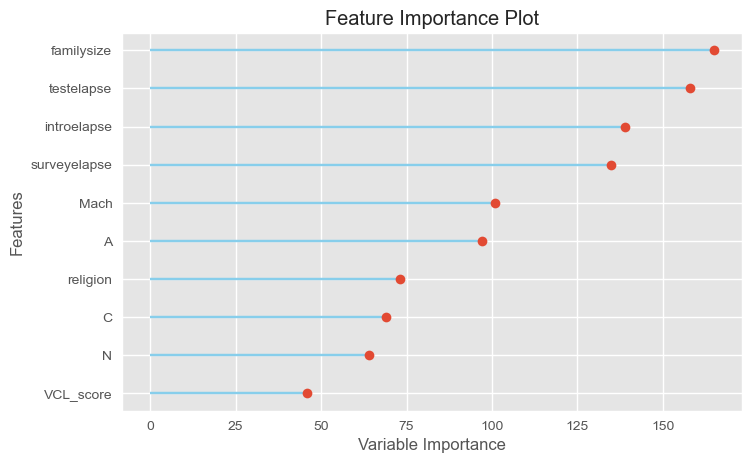

In [167]:
plot_model(model_lgbm, plot='feature')

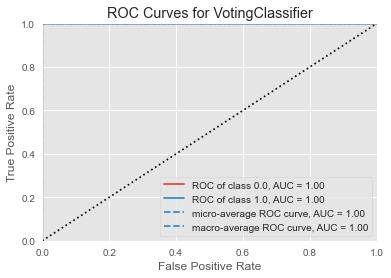

In [161]:
plot_model(blender_top5, plot='auc')

## Prediction for Test data 

In [335]:
# for total models 
for model in total_models : 
    prediction = predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7980,0.8831,0.8380,0.8082,0.8228,0.5881,0.5886


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7953,0.8818,0.8457,0.8000,0.8222,0.5815,0.5828


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7880,0.8712,0.8249,0.8020,0.8133,0.5682,0.5685


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7760,0.8602,0.8213,0.7875,0.8041,0.5429,0.5435


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7967,0.8649,0.8243,0.8146,0.8194,0.5868,0.5868


In [336]:
# for tuned models 
for model in tuned_models : 
    prediction = predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7980,0.8831,0.8380,0.8082,0.8228,0.5881,0.5886


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7953,0.8818,0.8457,0.8000,0.8222,0.5815,0.5828


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8067,0.8881,0.8517,0.8120,0.8314,0.6051,0.6061


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7887,0.8649,0.8273,0.8015,0.8142,0.5694,0.5697


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7907,0.8944,0.9446,0.7478,0.8347,0.5596,0.5886


In [337]:
# for blended model 
prediction = predict_model(blender_top5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8123,0.9016,0.8964,0.7946,0.8424,0.6125,0.6193


# 6. Submission

In [264]:
pred = predict_model(blender_top5, raw_score=True)
pred[['Label', 'Score_1.0']].head(20)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.3460,0,0.0000,0.0000,0.0000,0.0000,0.0000


,Label,Score_1.0
0,0.0,0.2259
1,1.0,0.8764
2,1.0,0.8876
3,1.0,0.6886
4,1.0,0.8955
5,0.0,0.0435
6,1.0,0.7428
7,1.0,0.8984
8,0.0,0.4344
9,1.0,0.5561


In [265]:
# 제출용 sample 파일을 불러옵니다.
submission = pd.read_csv(path + 'sample_submission.csv')
submission.head()

,index,nerdiness
0,0,-1
1,1,-1
2,2,-1
3,3,-1
4,4,-1


In [266]:
# 위에서 구한 예측값을 그대로 넣어줍니다.
submission['nerdiness'] = pred['Score_1.0']

# 데이터가 잘 들어갔는지 확인합니다.
submission

,index,nerdiness
0,0,0.2259
1,1,0.8764
2,2,0.8876
3,3,0.6886
4,4,0.8955
...,...,...
35447,35447,0.8519
35448,35448,0.8864
35449,35449,0.9460
35450,35450,0.2680


In [267]:
import datetime
filename = datetime.datetime.now().strftime("%m%d_%H_%M_%S")
filename

'0824_18_30_30'

In [268]:
submission.to_csv(path+"{}.csv".format(filename), index=False)

# 7. Saving Models

In [155]:
final_model = blender_top5 # you should fill out this 

In [40]:
# makes overfitting!! 
final_model = finalize_model(blender_top5) # you should fill out this 

In [156]:
import datetime
filename = datetime.datetime.now().strftime("%m%d_%H_%M")
filename = 'AUC90_alltrain_'+filename
filename

'AUC90_alltrain_0812_21_30'

In [157]:
save_model(final_model,path+filename)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['urban',
                                                             'education',
                                                             'gender', 'engnat',
                                                             'hand', 'religion',
                                                             'orientation',
                                                             'voted', 'married',
                                                             'ASD', 'Q1', 'Q2',
                                                             'Q3', 'Q4', 'Q5',
                                                             'Q6', 'Q7', 'Q8',
                                                             'Q9', 'Q10', 'Q11',
                                                             'Q12', 'Q13', 'Q14',
                                                             'Q15', 'Q16', 'Q17',
   